Evaluation of SVR and gradient boosting regression on steel dataset

In [6]:

#Data prepocessing
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, cross_validate, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.ensemble import GradientBoostingRegressor


# Load dataset
df = pd.read_csv("steel.csv")

X = df.drop("tensile_strength", axis=1)
y = df["tensile_strength"]

rmse = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)))
r2 = make_scorer(r2_score)


# 10-fold cross-validation (default hyperparameters)
model = GradientBoostingRegressor()

cv = KFold(n_splits=10, shuffle=True, random_state=67)

cv_results = cross_validate(
    model,
    X, y,
    cv=cv,
    scoring={'RMSE': rmse, 'R2': r2},
    return_train_score=True
)

print("=== Default Hyperparameters ===")
print("Average Train RMSE:", np.mean(cv_results['train_RMSE']))
print("Average Test RMSE:", np.mean(cv_results['test_RMSE']))
print("Average Train R2:", np.mean(cv_results['train_R2']))
print("Average Test R2:", np.mean(cv_results['test_R2']))

=== Default Hyperparameters ===
Average Train RMSE: 16.97074434820655
Average Test RMSE: 28.319596430294503
Average Train R2: 0.9652491804618029
Average Test R2: 0.9002636882043417


In [ ]:
#Gradient Boosting optimisation for RMSE
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 300, 500]
}

tuned_model = GridSearchCV(
    estimator=GradientBoostingRegressor(),
    param_grid=param_grid,
    scoring=['neg_mean_squared_error' 'r2'], 
    refit='neg_mean_squared_error',  
    cv=cv,
    n_jobs=-1
)

tuned_model.fit(X, y)

print("\n------ Best Hyperparameters ------")
print(tuned_model.best_params_)

# ---------------------------
# Evaluate tuned model
# ---------------------------
best_model = tuned_model.best_estimator_

tuned_results = cross_validate(
    best_model,
    X, y,
    cv=cv,
    scoring={'RMSE': rmse, 'R2': r2},
    return_train_score=True
)

print("\n------ Tuned Hyperparameter Results ------")
print("Train RMSE:", np.mean(tuned_results['train_RMSE']))
print("Test RMSE :", np.mean(tuned_results['test_RMSE']))
print("Train R²  :", np.mean(tuned_results['train_R2']))
print("Test R²   :", np.mean(tuned_results['test_R2']))

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3227314878.py, line 11)

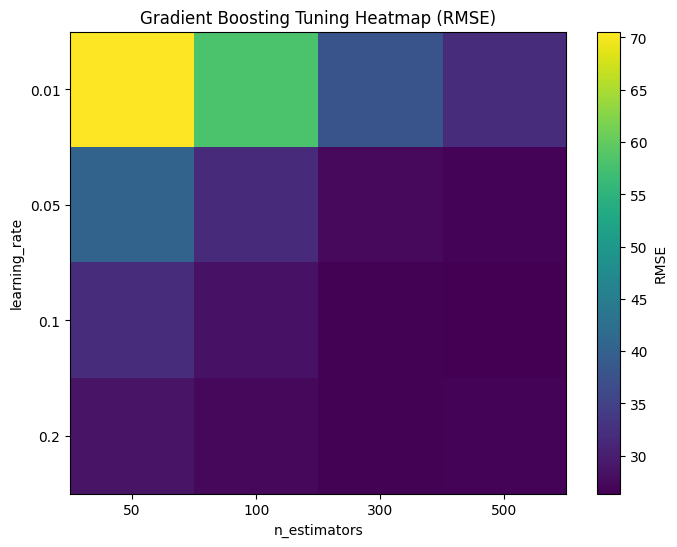

In [ ]:
##Graph for best values for RMSE and R^2
import matplotlib.pyplot as plt

results = pd.DataFrame(tuned_model.cv_results_)


heatmap_rmse = results.pivot(index='param_learning_rate', columns='param_n_estimators', values='RMSE')
heatmap_r2   = results.pivot(index='param_learning_rate', columns='param_n_estimators', values='R2')



fig, axes = plt.subplots(1, 2, figsize=(14, 5))

im0 = axes[0].imshow(heatmap_rmse, cmap='viridis', aspect='auto')
axes[0].set_title('RMSE (lower better)')
axes[0].set_xlabel('n_estimators')
axes[0].set_ylabel('learning_rate')
axes[0].set_xticks(range(len(heatmap_rmse.columns))); axes[0].set_xticklabels(heatmap_rmse.columns)
axes[0].set_yticks(range(len(heatmap_rmse.index)));  axes[0].set_yticklabels(heatmap_rmse.index)
fig.colorbar(im0, ax=axes[0], label='RMSE')

im1 = axes[1].imshow(heatmap_r2, cmap='viridis', aspect='auto')
axes[1].set_title('R² (higher better)')
axes[1].set_xlabel('n_estimators')
axes[1].set_ylabel('learning_rate')
axes[1].set_xticks(range(len(heatmap_r2.columns))); axes[1].set_xticklabels(heatmap_r2.columns)
axes[1].set_yticks(range(len(heatmap_r2.index)));  axes[1].set_yticklabels(heatmap_r2.index)
fig.colorbar(im1, ax=axes[1], label='R²')

plt.tight_layout()
plt.show()